# BCI-Motor imagery Data Preprocessing

- Import data and check stimulus events

In [204]:
import mne
import numpy as np
raw_edf = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\class3_pipo_edf.edf",preload = True)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\class3_pipo_edf.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 107749  =      0.000 ...   430.996 secs...


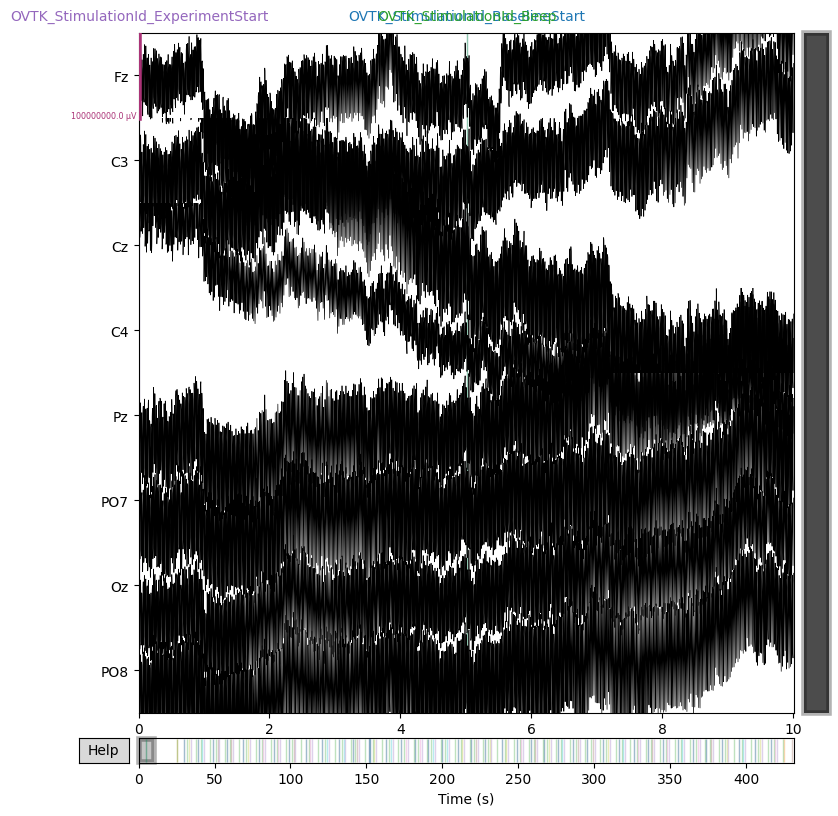

...


In [205]:
raw_edf.plot(
    duration=10, 
    start=0.0, 
    scalings=50, # You may edit scalings value later
    )
print("...")

In [206]:
max(raw_edf[6][0][0])

95823.09

# Feature Extraction

- MRCP , LF-ASD (try to add sapatial filter later)

In [207]:
eeg1 = raw_edf.copy().filter(l_freq=1.0, h_freq=3.0, method = 'iir', iir_params= {"order": 12, "ftype":'butter'})
eeg1 = eeg1.copy().set_eeg_reference(ref_channels="average")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 48 (effective, after forward-backward)
- Cutoffs at 1.00, 3.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


c:\Python311\Lib\site-packages\scipy\signal\_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


In [208]:
max(eeg1[0][0][0])

294.9128006203801

In [209]:
eeg1= eeg1.pick_channels(['C3','Cz','C4'])
events, event_dict = mne.events_from_annotations(eeg1)
epochs = mne.Epochs(eeg1, events, 
        tmin=-1.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=3.0,    # final timestamp (10 means set epoch duration 10 second)
        baseline=(0, 0),
        event_id=event_dict,
        preload = True,
        event_repeated='drop'
    )

Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_Train']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
205 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 205 events and 1126 original time points ...
2 bad epochs dropped


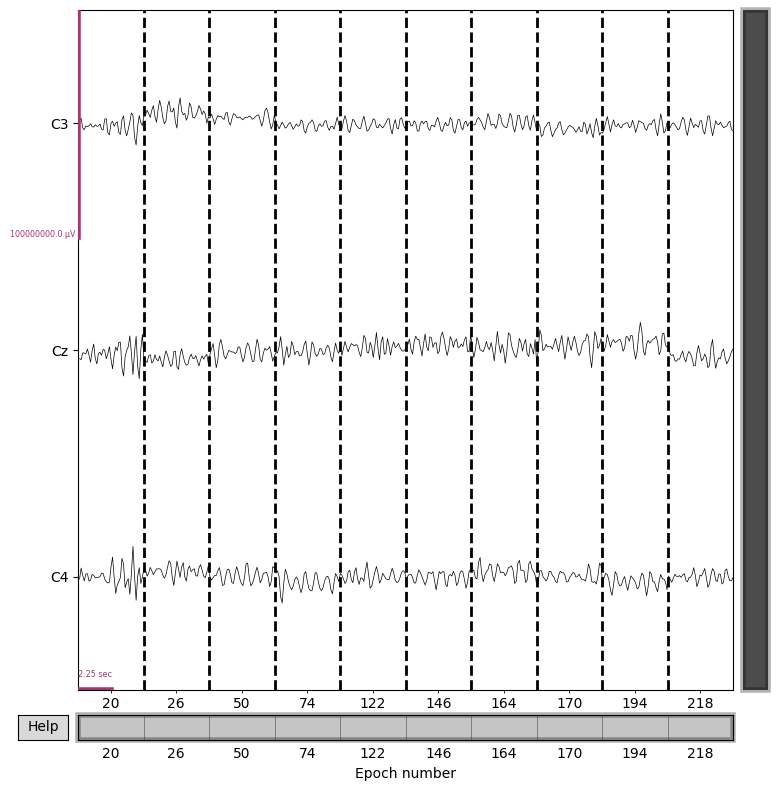

In [210]:
epochs['OVTK_GDF_Left'].plot(
    scalings=50, # You may edit scalings value later
    title='Left stimuli start',
)
left = epochs['OVTK_GDF_Left'].average()

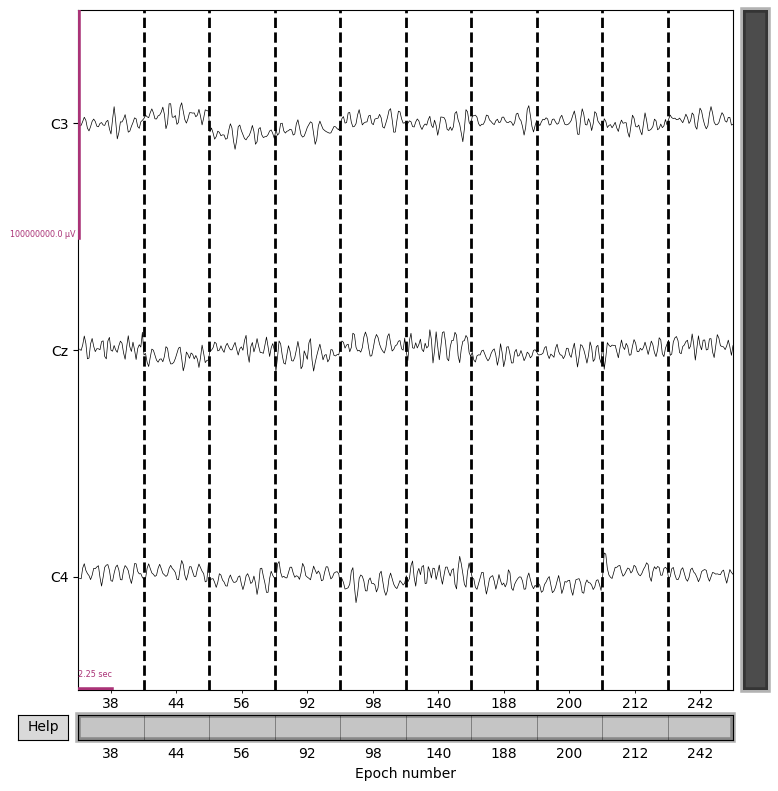

In [211]:
epochs['OVTK_GDF_Right'].plot(
    scalings=50, # You may edit scalings value later
    title='Left stimuli start',
)
right = epochs['OVTK_GDF_Right'].average()

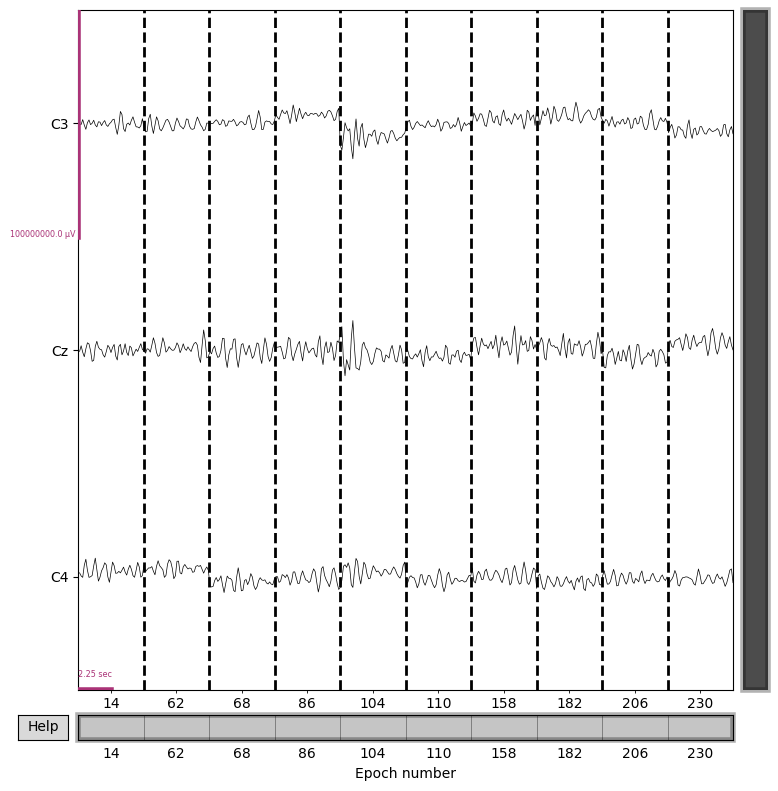

In [212]:
epochs['OVTK_GDF_Up'].plot(
    scalings=50, # You may edit scalings value later
    title='Left stimuli start',
)
up = epochs['OVTK_GDF_Up'].average()

Need more than one channel to make topography for eeg. Disabling interactivity.


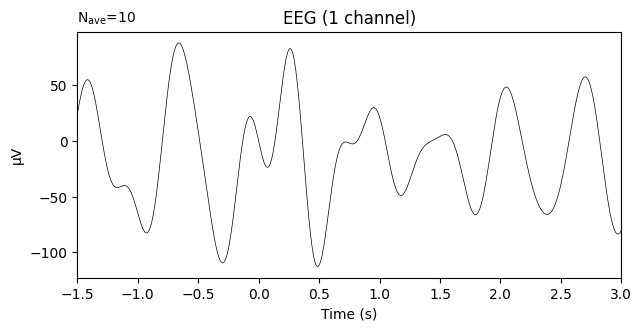

Need more than one channel to make topography for eeg. Disabling interactivity.


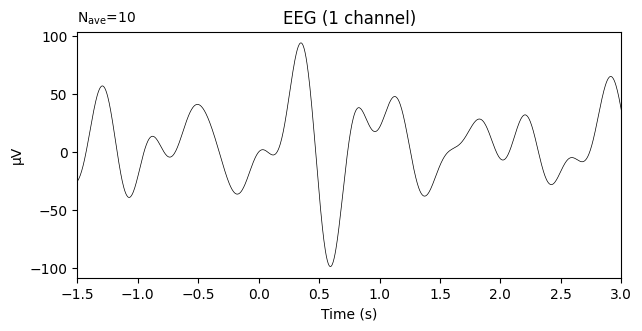

Need more than one channel to make topography for eeg. Disabling interactivity.


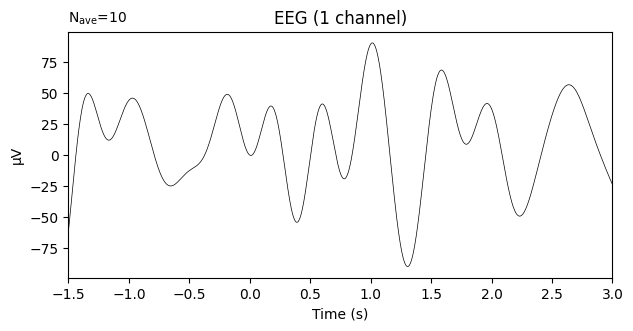

...


In [213]:
up.plot(scalings=50, picks="Cz")
left.plot(scalings=50, picks="C4")
right.plot(scalings=50, picks="C3")
print("...")

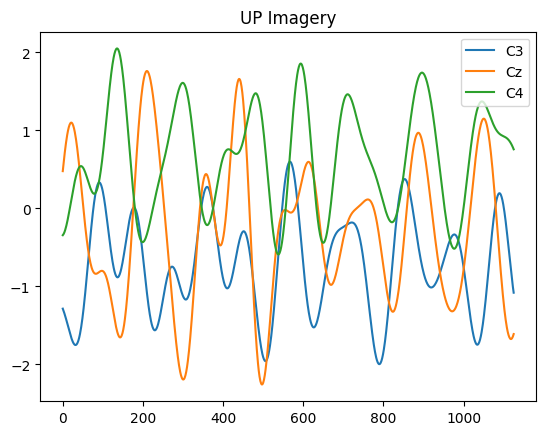

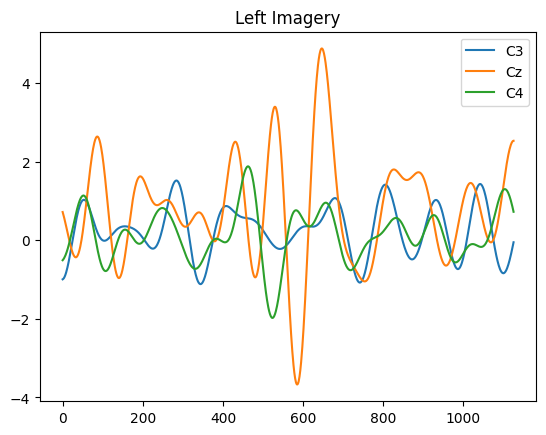

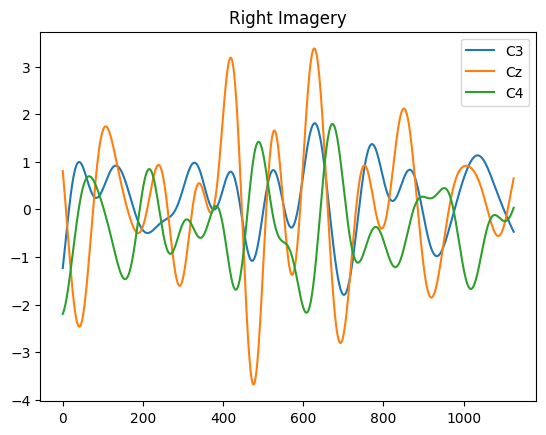

In [214]:
import matplotlib.pyplot as plt
plt.plot(up.get_data()[0],label='C3')
plt.plot(up.get_data()[1],label='Cz')
plt.plot(up.get_data()[2],label='C4')
plt.title('UP Imagery')
plt.legend()
plt.show()

plt.plot(left.get_data()[0],label='C3')
plt.plot(left.get_data()[1],label='Cz')
plt.plot(left.get_data()[2],label='C4')
plt.title('Left Imagery')
plt.legend()
plt.show()

plt.plot(right.get_data()[0],label='C3')
plt.plot(right.get_data()[1],label='Cz')
plt.plot(right.get_data()[2],label='C4')
plt.title('Right Imagery')
plt.legend()
plt.show()

- ERD/ERS

- PSD

- CSP

- CWT

- STFT